<a href="https://colab.research.google.com/github/birddropping/IND5003-Group-Project/blob/main/IND5003_Group_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [166]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
#from functools import reduce

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.width', 1000)

%matplotlib inline

In [167]:
data_demo = pd.read_csv('data/demographic.csv')
data_diet = pd.read_csv('data/diet.csv')
data_exam = pd.read_csv('data/examination.csv')
data_labs = pd.read_csv('data/labs.csv')
data_meds = pd.read_csv('data/medications.csv', encoding = "ISO-8859-1") # Had to use this encoding standard to read file
data_qns = pd.read_csv('data/questionnaire.csv')
data_dict = pd.read_excel('NHANES 2014 Dictionary.xlsx')

data_vari = pd.read_excel('Variables.xlsx', squeeze = True)

In [168]:
glu_data = pd.read_sas('data/GLU_H.XPT') # Fasting glucose was not part of the original dataset. Added from NHANES website
vitd_data = pd.read_sas('data/VID_H.XPT')
data_labs = pd.merge(data_labs, glu_data[['SEQN','LBDGLUSI']], how='outer', on=['SEQN'], validate = '1:1')
data_labs = pd.merge(data_labs, vitd_data[['SEQN','LBXVIDMS']], how='outer', on=['SEQN'], validate = '1:1')


In [169]:
#remove duplicates from data_meds as each line covers 1 medication
data_meds_m = data_meds.drop_duplicates(subset = ['SEQN', 'RXDCOUNT'], keep = 'first')

#create a data frame with the illnesses and drugs plus 1 last column whether SEQN is diabetic or not
data_med_2=data_demo.loc[:,['SEQN']]
imax=len(data_demo['SEQN'])
druglist=data_meds['RXDDRUG']
illnesslist=data_meds['RXDRSD1']
med_SEQN=data_meds['SEQN']
SEQN=data_demo['SEQN']

for i in range(0,imax):
    string=''
    lis1=druglist.loc[data_meds['SEQN']==SEQN[i]]
    string=lis1.str.cat(sep=',').upper()
    data_med_2.loc[i,['druglist']]=string
    if string.find('INSULIN') >= 0:
        data_med_2.loc[i,['TAKE INSULIN']]='YES'
    else:
        data_med_2.loc[i,['TAKE INSULIN']]='NO'
    
    lis2=illnesslist.loc[data_meds['SEQN']==SEQN[i]].drop_duplicates(keep='first')
    
    string=lis2.str.cat(sep=',').upper()
    data_med_2.loc[i,['illness']]=string
    #check whether diabetetic
    if string.find('TYPE 1 DIAB') >= 0:
        data_med_2.loc[i,['DBT']]='TYPE 1'
    elif string.find('TYPE 2 DIAB') >= 0:
        data_med_2.loc[i,['DBT']]='TYPE 2'    
    elif string.find('PREVENT DIAB') >= 0:
        data_med_2.loc[i,['DBT']]='HIGH RISK'
    else:
        data_med_2.loc[i,['DBT']]='OTHERS'

        

Combine the 6 datasets together as 1 with SEQN as the lead. From there, we can trim out the variables that is not needed for our application of diabetes and mental health.

In [170]:
# Create massive dataset
dataset = pd.merge(data_demo, data_diet, how = 'outer', on = ['SEQN'], validate = "1:1")
dataset = pd.merge(dataset, data_exam, how = 'outer', on = ['SEQN'], validate = "1:1")
dataset = pd.merge(dataset, data_labs, how = 'outer', on = ['SEQN'], validate = "1:1")
dataset = pd.merge(dataset, data_meds_m, how = 'outer', on = ['SEQN'], validate = "1:1")
dataset = pd.merge(dataset, data_qns, how = 'outer', on = ['SEQN'], validate = "1:1")
dataset = pd.merge(dataset, data_med_2, how = 'outer', on = ['SEQN'], validate = "1:1")

dataset.loc[(dataset['LBXGH']<=5.6),'Diabetic']='NO'
dataset['LBXGH'].fillna(value=0)
dataset.loc[((dataset['LBXGH']>5.6) & (dataset['LBXGH']<=6.4)),'Diabetic']='PREDIABETES'
dataset.loc[(dataset['LBXGH']>6.4),'Diabetic']='YES'

print(dataset['Diabetic'])

0        YES
1        YES
2        YES
3        NaN
4         NO
        ... 
10170     NO
10171    NaN
10172     NO
10173    NaN
10174    NaN
Name: Diabetic, Length: 10175, dtype: object


In [171]:
# Create list of variables of interest
col_list = data_vari.tolist()

# Creating dataframe with variables of interest
final_data = dataset[col_list]

# Subsetting based on glycohaemoglobin levels
final_data = final_data.dropna(subset=['LBXGH']) 
final_data

,SEQN,RXDCOUNT,RXDDAYS,RIAGENDR,RIDAGEYR,RIDRETH1,BMXBMI,BPXSY1,BPXDI1,BPXSY2,BPXDI2,BPXSY3,BPXDI3,DR1TALCO,DR1.320Z,LBDGLTSI,LBDGLUSI,LBDHDDSI,LBDTCSI,LBXVIDMS,LBXGH,DIQ160,DIQ170,DIQ172,DIQ175A,DBD895,DBD900,DBD905,DBD910,FSD151,FSQ165,INDHHIN2,INDFMIN2,DPQ010,DPQ020,DPQ030,DPQ040,DPQ050,DPQ060,DPQ070,DPQ080,DPQ090,DPQ100,PAQ605,PAQ610,PAD615,PAQ620,PAQ625,PAD630,PAQ635,PAQ640,PAD645,PAQ650,PAQ655,PAD660,PAQ665,PAQ670,PAD675,PAD680,PAQ710,PAQ715,WHQ030,WHQ070,DBQ700,HSD010,WHD110,WHD120,BMXWT
0,73557,2.0,NaN,1,69,4,26.7,122.0,72.0,114.0,76.0,102.0,74.0,0.0,960.0,NaN,NaN,1.68,4.32,28.9,13.9,NaN,NaN,NaN,NaN,8.0,8.0,0.0,4.0,2.0,1.0,4.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,600.0,2.0,8.0,3.0,NaN,2.0,2.0,270.0,200.0,78.3
1,73558,4.0,243.0,1,54,3,28.6,156.0,62.0,160.0,80.0,156.0,42.0,119.0,360.0,NaN,NaN,1.29,4.40,61.9,9.1,NaN,NaN,NaN,NaN,0.0,NaN,0.0,2.0,2.0,1.0,7.0,7.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,NaN,NaN,1.0,1.0,10.0,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,540.0,4.0,8.0,3.0,2.0,3.0,4.0,240.0,250.0,89.5
2,73559,5.0,365.0,1,72,3,28.9,140.0,90.0,140.0,76.0,146.0,80.0,0.0,1254.0,NaN,10.713,1.55,3.26,126.0,8.9,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,2.0,2.0,10.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,2.0,NaN,NaN,1.0,7.0,30.0,2.0,NaN,NaN,2.0,NaN,NaN,1.0,1.0,180.0,300.0,4.0,0.0,3.0,2.0,3.0,3.0,180.0,190.0,88.9
4,73561,4.0,152.0,2,73,3,19.7,136.0,86.0,134.0,88.0,142.0,86.0,0.0,240.0,NaN,5.940,2.20,5.20,108.0,4.9,2.0,2.0,2.0,NaN,0.0,NaN,4.0,1.0,2.0,2.0,15.0,15.0,2.0,1.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,1.0,2.0,NaN,NaN,1.0,2.0,30.0,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,480.0,1.0,1.0,2.0,2.0,2.0,5.0,150.0,135.0,52.0
5,73562,7.0,365.0,1,56,1,41.7,160.0,84.0,158.0,82.0,154.0,80.0,0.0,1014.0,NaN,NaN,0.98,5.84,44.3,5.5,2.0,2.0,1.0,NaN,14.0,14.0,0.0,0.0,2.0,2.0,9.0,9.0,3.0,3.0,3.0,3.0,3.0,1.0,2.0,1.0,0.0,3.0,1.0,5.0,240.0,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,360.0,5.0,8.0,1.0,1.0,5.0,5.0,225.0,195.0,105.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10164,83721,1.0,91.0,1,52,3,25.6,108.0,70.0,112.0,72.0,108.0,76.0,0.0,0.0,NaN,NaN,1.42,3.57,109.0,5.4,2.0,2.0,2.0,NaN,15.0,0.0,0.0,0.0,2.0,2.0,15.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,1.0,4.0,120.0,1.0,3.0,120.0,240.0,2.0,8.0,3.0,2.0,1.0,2.0,172.0,163.0,79.5
10166,83723,NaN,NaN,1,61,1,33.1,NaN,NaN,138.0,60.0,142.0,68.0,0.0,3000.0,NaN,8.826,1.27,4.81,59.4,7.4,NaN,NaN,NaN,NaN,1.0,0.0,0.0,2.0,2.0,1.0,10.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,1.0,2.0,30.0,360.0,3.0,8.0,1.0,NaN,3.0,4.0,240.0,200.0,99.5
10167,83724,5.0,10950.0,1,80,3,24.9,164.0,70.0,168.0,66.0,168.0,66.0,0.0,690.0,NaN,NaN,1.32,4.06,89.9,5.5,2.0,2.0,2.0,NaN,1.0,1.0,0.0,30.0,2.0,2.0,8.0,8.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,1.0,7.0,60.0,360.0,2.0,8.0,3.0,2.0,2.0,2.0,173.0,140.0,77.1
10170,83727,NaN,NaN,1,26,2,24.5,110.0,68.0,116.0,74.0,112.0,76.0,14.0,867.0,5.995,5.995,1.42,4.91,81.5,5.0,2.0,2.0,2.0,NaN,1.0,1.0,2.0,2.0,2.0,2.0,77.0,77.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,600.0,2.0,1.0,3.0,2.0,4.0,3.0,NaN,NaN,71.8


As shown in previous cell, all datasets have been combined and only features related to diabetes and mental health have been filtered out to create the dataset from which analysis will be done.

In [172]:
SES = ['INDHHIN2', 'INDFMIN2', 'FSD151', 'FSQ165']
SES_data = final_data[SES]
SES_data

,INDHHIN2,INDFMIN2,FSD151,FSQ165
0,4.0,4.0,2.0,1.0
1,7.0,7.0,2.0,1.0
2,10.0,10.0,2.0,2.0
4,15.0,15.0,2.0,2.0
5,9.0,9.0,2.0,2.0
...,...,...,...,...
10164,15.0,15.0,2.0,2.0
10166,10.0,10.0,2.0,1.0
10167,8.0,8.0,2.0,2.0
10170,77.0,77.0,2.0,2.0


In [173]:
SES_data.describe()

,INDHHIN2,INDFMIN2,FSD151,FSQ165
count,6560.000000,6565.000000,6572.000000,6572.000000
mean,11.033994,10.614166,1.894553,1.683810
std,13.886365,13.706318,0.321673,0.514433
min,1.000000,1.000000,1.000000,1.000000
25%,5.000000,5.000000,2.000000,1.000000
50%,8.000000,7.000000,2.000000,2.000000
75%,14.000000,14.000000,2.000000,2.000000
max,99.000000,99.000000,7.000000,9.000000


Coded results for household/family income

|Value|Salary Range|
|-----|------------|
|1|0 to 4999|
|2|5000 to 9999|
|3|10000 to 14999|
|4|15000 to 19999|
|5|20000 to 24999|
|6|25000 to 34999|
|7|35000 to 44999|
|8|45000 to 54999|
|9|55000 to 64999|
|10|65000 to 74999|
|12|20000 and over|
|13|under 20000|
|14|75000 to 99999|
|15|100000 and over|

We will have to replace NaN values, 77 and 99 which are refuse to answer and do not know respectively.

In [174]:
#Replace 77.0 and 99.0 with NaN value first, before replacing all NaN values with the mean of the remainder.
SES_data.loc[:,'INDHHIN2'] = SES_data.loc[:,'INDHHIN2'].replace(77.0, np.NaN)
SES_data.loc[:,'INDHHIN2'] = SES_data.loc[:,'INDHHIN2'].replace(99.0, np.NaN)
#Round function used to keep integer values only within the Dataframe
SES_data.loc[:,'INDHHIN2'] = SES_data.loc[:,'INDHHIN2'].fillna(round(SES_data.loc[:,'INDHHIN2'].mean()))

SES_data.loc[:,'INDFMIN2'] = SES_data.loc[:,'INDFMIN2'].replace(77.0, np.NaN)
SES_data.loc[:,'INDFMIN2'] = SES_data.loc[:,'INDFMIN2'].replace(99.0, np.NaN)
#Round function used to keep integer values only within the Dataframe
SES_data.loc[:,'INDFMIN2'] = SES_data.loc[:,'INDFMIN2'].fillna(round(SES_data.loc[:,'INDFMIN2'].mean()))

E:\Users\tay_w\anaconda3\lib\site-packages\pandas\core\indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


In [175]:
#Too many catergories that are not in order to make sense when plotting a histogram
#Convert data values to only have 4 catergories

#Cat 1 is under 20000
replace_values_cat1 = {2:1, 3:1, 4:1, 13:1}
#Cat 2 is 20000 to 74999
replace_values_cat2 = {5:2, 6:2, 7:2, 8:2, 9:2, 10:2, 12:2}
#Cat 3 is 75000 to 99999
replace_values_cat3 = {14:3}
#Cat 4 is 100000 and above
replace_values_cat4 = {15:4}

#Replace the values in 'INDHHIN2' to create 4 catergories
SES_data['INDHHIN2'].replace(replace_values_cat1, inplace=True)
SES_data['INDHHIN2'].replace(replace_values_cat2, inplace=True)
SES_data['INDHHIN2'].replace(replace_values_cat3, inplace=True)
SES_data['INDHHIN2'].replace(replace_values_cat4, inplace=True)

#Replace the values in 'INDFMIN2' to create 4 catergories
SES_data['INDFMIN2'].replace(replace_values_cat1, inplace=True)
SES_data['INDFMIN2'].replace(replace_values_cat2, inplace=True)
SES_data['INDFMIN2'].replace(replace_values_cat3, inplace=True)
SES_data['INDFMIN2'].replace(replace_values_cat4, inplace=True)

final_data['INDFMIN2'] = SES_data['INDFMIN2']
final_data['INDHHIN2'] = SES_data['INDHHIN2']

E:\Users\tay_w\anaconda3\lib\site-packages\pandas\core\generic.py:6610: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [176]:
check=[11]
#check that the value 11 is not in the column as it is not represented in the value coding table above for feature
# INDHHIN2 and INDFMIN2 which are household income and family income respectively
SES_data['INDHHIN2'].isin(check).sum()

0

In [177]:
#Should be removed before main integration for project submission

SES_data['INDFMIN2'].isin(check).sum()

0

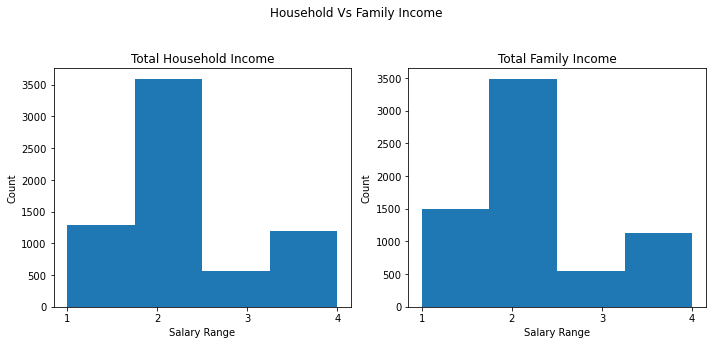

In [178]:
#Plot the income indicators into histograms according to the new catergories that we arranged them in

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

ax1.hist(SES_data['INDHHIN2'], bins=4)
ax1.set_ylabel("Count")
ax1.set_xlabel("Salary Range")
ax1.set_title("Total Household Income")
ax1.set_xticks([1,2,3,4]) 
ax1.set_xticklabels([1,2,3,4])

ax2.hist(SES_data['INDFMIN2'], bins=4)
ax2.set_ylabel("Count")
ax2.set_xlabel("Salary Range")
ax2.set_title("Total Family Income")
ax2.set_xticks([1,2,3,4]) 
ax2.set_xticklabels([1,2,3,4])

fig.suptitle("Household Vs Family Income")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [179]:
SES_data['FSD151'].replace(7.0, np.NaN, inplace=True)
SES_data['FSD151'].replace(9.0, np.NaN, inplace=True)
#Round function used to keep integer values only within the Dataframe
SES_data['FSD151'].fillna(round(SES_data['FSD151'].mean()), inplace=True)

SES_data['FSQ165'].replace(7.0, np.NaN, inplace=True)
SES_data['FSQ165'].replace(9.0, np.NaN, inplace=True)
#Round function used to keep integer values only within the Dataframe
SES_data['FSQ165'].fillna(round(SES_data['FSQ165'].mean()), inplace=True)

final_data['FSD151'] = SES_data['FSD151']
final_data['FSQ165'] = SES_data['FSQ165']

E:\Users\tay_w\anaconda3\lib\site-packages\pandas\core\generic.py:6383: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


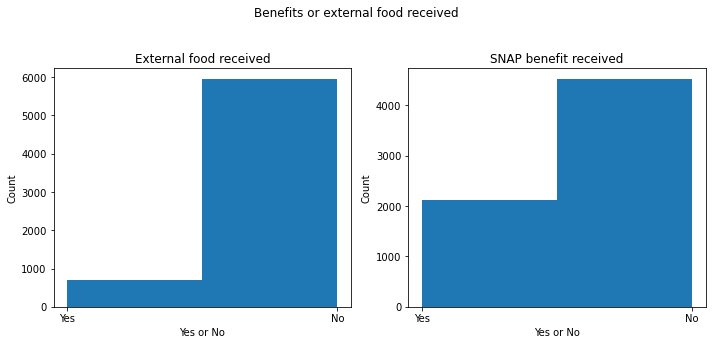

In [180]:
# Features showing benefit

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

ax1.hist(SES_data['FSD151'], bins=2)
ax1.set_ylabel("Count")
ax1.set_xlabel("Yes or No")
ax1.set_title("External food received")
ax1.set_xticks([1,2]) 
ax1.set_xticklabels(['Yes','No'])

ax2.hist(SES_data['FSQ165'], bins=2)
ax2.set_ylabel("Count")
ax2.set_xlabel("Yes or No")
ax2.set_title("SNAP benefit received")
ax2.set_xticks([1,2]) 
ax2.set_xticklabels(['Yes','No'])

fig.suptitle("Benefits or external food received")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [181]:
# subsetting dataset based on available HbA1c data
mh = ['SEQN','DPQ010','DPQ020','DPQ030','DPQ040','DPQ050','DPQ060','DPQ070','DPQ080','DPQ090','DPQ100']
mental_health = final_data[mh]
final_data.loc[:,'DPQ_score'] = mental_health.drop('SEQN', axis=1).sum(axis=1) # summing up scores

# mental health summary statistic - 4 categories - 0 for normal, 1 for mild, 2 for moderate, 3 for severe
final_data.loc[:,'mental_health_stat'] = pd.cut(final_data['DPQ_score'], [0,4,9,14,27], labels=[0,1,2,3], include_lowest = True)

final_data = final_data.drop(['DPQ010','DPQ020','DPQ030','DPQ040','DPQ050','DPQ060','DPQ070','DPQ080','DPQ090','DPQ100'], axis=1)

array([[<AxesSubplot:title={'center':'0'}>,
        <AxesSubplot:title={'center':'1'}>],
       [<AxesSubplot:title={'center':'2'}>,
        <AxesSubplot:title={'center':'3'}>]], dtype=object)

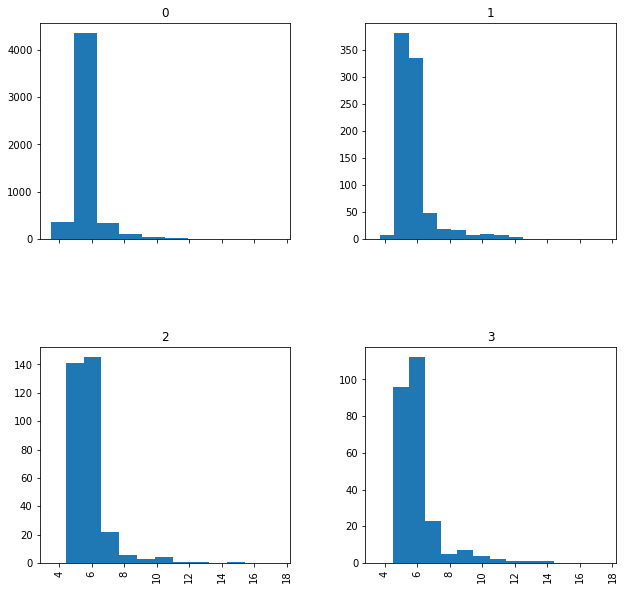

In [182]:
final_data.hist(by='mental_health_stat', column = 'LBXGH',figsize=(10,10), sharex = True)

In [183]:
# selecting average value for individuals with no inputs, replacing 'unsure' responses with average value
final_data.loc[:,'WHQ030'] = final_data['WHQ030'].fillna(3).replace(9,3) 
# selecting 'no' for individuals who did not respond to this qn, replacing 'unsure' responses with nil response
final_data.loc[:,'WHQ070'] = final_data['WHQ070'].fillna(2).replace(9,2) 
# selecting average value for individuals with no inputs, replacing 'unsure' responses with average value
final_data.loc[:,'DBQ700'] = final_data['DBQ700'].fillna(3).replace(9,3)
# selecting average value for individuals with no inputs, replacing 'unsure' responses with average value\
final_data.loc[:,'HSD010'] = final_data['HSD010'].fillna(3).replace(9,3)

# Subsetting and creating scores for individual self-perception questions
sp = ['SEQN','WHQ030','WHQ070','DBQ700', 'HSD010']
self_perception = final_data[sp]
self_perception.loc[:,'WHQ030_score'] = self_perception['WHQ030'].replace([1,2],0).replace(3,2)
self_perception.loc[:,'WHQ070_score'] = self_perception['WHQ070'].replace(1,0)
self_perception.loc[:,'DBQ700_score'] = self_perception['DBQ700']-1
self_perception.loc[:,'HSD010_score'] = self_perception['HSD010']-1

# Creating summary score for self perception
final_data.loc[:,'self_perception_stat'] = self_perception[['WHQ030_score','WHQ070_score','DBQ700_score','HSD010_score']].sum(axis=1)
final_data.loc[:,'self_perception_stat'] = pd.cut(final_data.loc[:,'DPQ_score'], [0,3,6,9,12], labels=[0,1,2,3], include_lowest = True)

final_data = final_data.drop(['WHQ030','WHQ070','DBQ700','HSD010'], axis=1)

E:\Users\tay_w\anaconda3\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


array([[<AxesSubplot:title={'center':'0'}>,
        <AxesSubplot:title={'center':'1'}>],
       [<AxesSubplot:title={'center':'2'}>,
        <AxesSubplot:title={'center':'3'}>]], dtype=object)

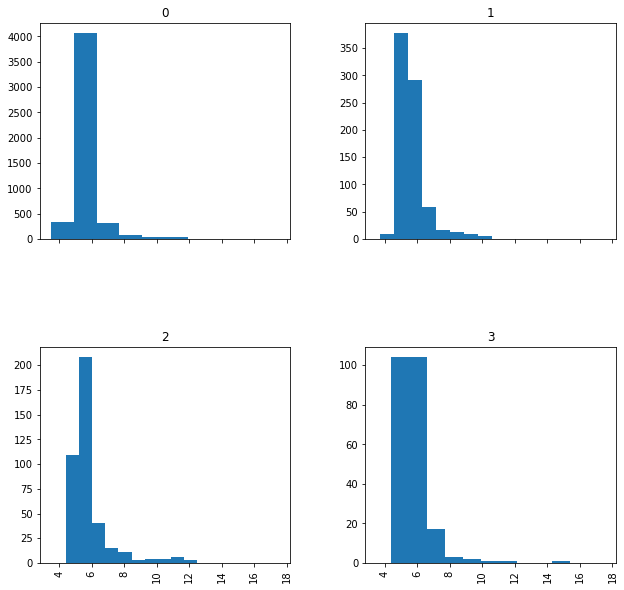

In [184]:
final_data.hist(by='self_perception_stat', column = 'LBXGH', figsize= (10,10), sharex = True)

In [185]:
wc = ['SEQN','WHD110','WHD120', 'BMXWT']
weight_change = final_data[wc]

weight_change.loc[:,'WHD110'] = weight_change.loc[:,'WHD110'].replace(7777,np.nan).replace(9999,np.nan) / 2.20462

weight_change.loc[:,'weight_change_10_years'] = weight_change.loc[:,'BMXWT'] - weight_change.loc[:,'WHD110']
final_data.loc[:,'wc_10yr_score'] = pd.cut(weight_change['weight_change_10_years'], [-120,-20,-5,5,20, 120], labels = [0, 1, 2, 3, 4])
final_data['wc_10yr_score'].replace(np.NaN,2,inplace=True)
final_data = final_data.drop(['WHD110','WHD120','BMXWT'], axis=1)

E:\Users\tay_w\anaconda3\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


array([[<AxesSubplot:title={'center':'0'}>,
        <AxesSubplot:title={'center':'1'}>],
       [<AxesSubplot:title={'center':'2'}>,
        <AxesSubplot:title={'center':'3'}>],
       [<AxesSubplot:title={'center':'4'}>, <AxesSubplot:>]], dtype=object)

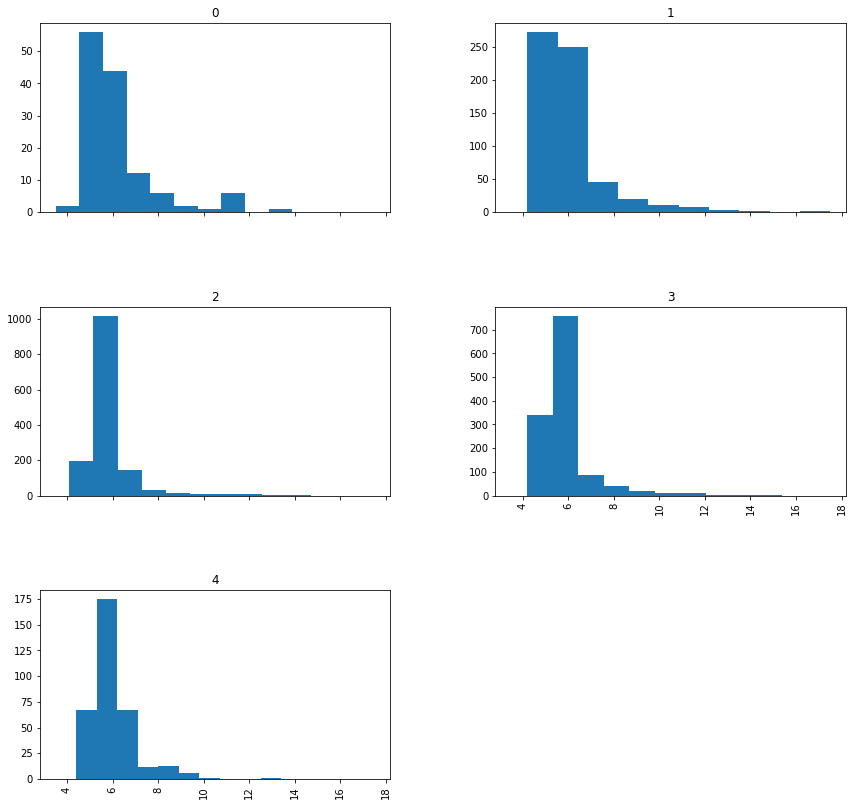

In [186]:
final_data.hist(by='wc_10yr_score', column='LBXGH', figsize = (14,14), sharex = True)

In [187]:
# Cleaning number of medications
final_data['RXDCOUNT'] = final_data['RXDCOUNT'].replace(np.NaN, 0)

# Defining average blood pressure
final_data.loc[:,'AVGSYBP'] = round(final_data[['BPXSY1','BPXSY2','BPXSY3']].mean(axis=1))
final_data.loc[:,'AVGDIBP'] = round(final_data[['BPXDI1','BPXDI2','BPXDI3']].mean(axis=1))

# Dropping base features relating to 1,2,3 measurements of Systolic and Diastolic BP
final_data = final_data.drop(['BPXSY1','BPXSY2','BPXSY3','BPXDI1','BPXDI2','BPXDI3'], axis=1)

# Cleaning data for DBD895. >21 responses normalized to 21. unsure participants normalized to mean number of meals
final_data['DBD895'] = final_data['DBD895'].replace({5555:21, 9999:np.NaN, 7777:np.NaN}).replace(np.NaN, round(np.mean(final_data['DBD895'])))
final_data['DBD900'] = final_data['DBD900'].replace({5555:21, 9999:np.NaN}).replace(np.NaN, round(np.mean(final_data['DBD900'])))
# Calculating proportion of fast food compared to all other meals consumed outside
avg_meals = final_data['DBD900'] / final_data['DBD895']
avg_meals = avg_meals.replace(np.inf, 0)
avg_meals = avg_meals.where(avg_meals < 1 ,1)
final_data['PROFFMEAL'] = avg_meals

final_data['DBD905'] = final_data['DBD905'].replace(9999, np.NaN).replace(np.NaN, round(np.mean(final_data['DBD905'])))   
final_data['DBD910'] = final_data['DBD910'].replace(9999, np.NaN).replace(np.NaN, round(np.mean(final_data['DBD910'])))   

final_data.drop(['RXDDAYS','LBDGLTSI','LBDGLUSI','DIQ160','DIQ170','DIQ172','DIQ175A','wc_10yr_score'],axis=1, inplace=True)

In [188]:
#Create working database for activity
activity = ["LBXGH","PAQ605", "PAQ620", "PAQ635", "PAQ650", "PAQ665", "PAD680", "PAQ710", "PAQ715"]
activity_wk = final_data.loc[:,activity]

#drop "PAQ706" due to poor data
#code out target variable "DM"
#code activity levels
activity1 = ["LBXGH","PAQ605", "PAQ620", "PAQ635", "PAQ650", "PAQ665", "PAD680", "PAQ710", "PAQ715"]
activity_wk = final_data.loc[:,activity1]
activity_wk["DM"] = activity_wk["LBXGH"]>6.5
activity_wk["activity_lvl_high"] = np.where((activity_wk.PAQ650 == 1) | (activity_wk.PAQ605 == 1), 1, np.NaN)
activity_wk["activity_lvl_med"] = np.where((activity_wk["PAQ620"] == 1) | (activity_wk["PAQ665"] == 1), 2, np.NaN)
activity_wk["activity_lvl_low"] =  (activity_wk["PAQ605" and "PAQ650" and "PAQ620" and "PAQ665"] !=1)


activity_wk["activity_lvl_low"].replace(True, 3, inplace=True)
activity_wk["activity_lvl_low"].replace(False, np.NaN, inplace=True)
#activity_wk[activity_wk["activity_lvl_high"]==0].replace(0,activity_wk["activity_lvl_med"], inplace=True )
#activity_wk["activity_lvl_high"].replace(0,activity_wk["activity_lvl_med"], inplace =True)
activity_wk["activity_lvl"] = activity_wk[["activity_lvl_high", "activity_lvl_med", "activity_lvl_low"]].min(axis=1)

final_data['activity_lvl'] = activity_wk['activity_lvl']

final_data.drop(["PAQ605",'PAQ610','PAD615', "PAQ620",'PAQ625','PAD630', "PAQ635", 'PAQ640','PAD645', "PAQ650", 'PAQ655','PAD660', "PAQ665", 'PAQ670','PAD675', "PAD680", "PAQ710", "PAQ715"], axis=1, inplace=True)

In [189]:
final_data.dropna(axis=0,how='any', inplace = True)

In [196]:
final_data

,SEQN,RXDCOUNT,RIAGENDR,RIDAGEYR,RIDRETH1,BMXBMI,DR1TALCO,DR1.320Z,LBDHDDSI,LBDTCSI,LBXVIDMS,LBXGH,DBD895,DBD900,DBD905,DBD910,FSD151,FSQ165,INDHHIN2,INDFMIN2,DPQ_score,mental_health_stat,self_perception_stat,AVGSYBP,AVGDIBP,PROFFMEAL,activity_lvl
0,73557,2.0,1,69,4,26.7,0.0,960.0,1.68,4.32,28.9,13.9,8.0,8.0,0.0,4.0,2.0,1.0,1.0,1.0,2.0,0,0,113.0,74.0,1.0,3.0
1,73558,4.0,1,54,3,28.6,119.0,360.0,1.29,4.40,61.9,9.1,0.0,4.0,0.0,2.0,2.0,1.0,2.0,2.0,2.0,0,0,157.0,61.0,0.0,2.0
2,73559,5.0,1,72,3,28.9,0.0,1254.0,1.55,3.26,126.0,8.9,1.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,0.0,0,0,142.0,82.0,0.0,2.0
4,73561,4.0,2,73,3,19.7,0.0,240.0,2.20,5.20,108.0,4.9,0.0,4.0,4.0,1.0,2.0,2.0,4.0,4.0,10.0,2,3,137.0,87.0,0.0,2.0
7,73564,3.0,2,61,3,35.7,34.2,1134.0,1.50,4.34,102.0,5.5,5.0,1.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,0,0,123.0,81.0,0.2,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10164,83721,1.0,1,52,3,25.6,0.0,0.0,1.42,3.57,109.0,5.4,15.0,0.0,0.0,0.0,2.0,2.0,4.0,4.0,0.0,0,0,109.0,73.0,0.0,1.0
10166,83723,0.0,1,61,1,33.1,0.0,3000.0,1.27,4.81,59.4,7.4,1.0,0.0,0.0,2.0,2.0,1.0,2.0,2.0,0.0,0,0,140.0,64.0,0.0,2.0
10167,83724,5.0,1,80,3,24.9,0.0,690.0,1.32,4.06,89.9,5.5,1.0,1.0,0.0,30.0,2.0,2.0,2.0,2.0,1.0,0,0,167.0,67.0,1.0,2.0
10170,83727,0.0,1,26,2,24.5,14.0,867.0,1.42,4.91,81.5,5.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,0,0,113.0,73.0,1.0,3.0


  
  
# DATA ANALYSIS
  
  

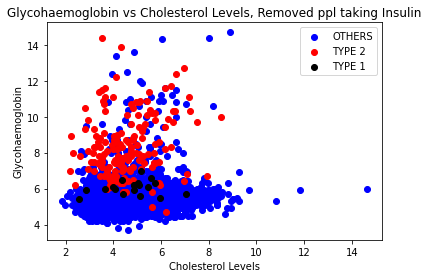

In [190]:
#pivot table of the database
tmp=dataset[['SEQN','DBT','TAKE INSULIN']]
tmp.describe()
#pv_tb=pd.pivot_table(tmp,index=['TAKE INSULIN','DBT'],aggfunc='count')
#print(pv_tb)

#scatter plot of lab values, 4 groups
#X1=dataset['LBDSCHSI'].loc[dataset['DBT']=='TYPE 1']
#X2=dataset['LBDSCHSI'].loc[dataset['DBT']=='TYPE 2']
#X1=dataset['LBDSCHSI'].loc[(dataset['DBT']=='TYPE 1') & (dataset['TAKE INSULIN']!='YES')]
X2=dataset['LBDSCHSI'].loc[(dataset['DBT']=='TYPE 2') & (dataset['TAKE INSULIN']!='NO')]
X3=dataset['LBDSCHSI'].loc[dataset['DBT']=='HIGH RISK']
X4=dataset['LBDSCHSI'].loc[dataset['DBT']=='OTHERS']

#Y1=dataset['LBXGH'].loc[dataset['DBT']=='TYPE 1']
#Y2=dataset['LBXGH'].loc[dataset['DBT']=='TYPE 2']
#Y1=dataset['LBXGH'].loc[(dataset['DBT']=='TYPE 1') & (dataset['TAKE INSULIN']!='YES')]
Y2=dataset['LBXGH'].loc[(dataset['DBT']=='TYPE 2') & (dataset['TAKE INSULIN']!='NO')]
Y3=dataset['LBXGH'].loc[dataset['DBT']=='HIGH RISK']
Y4=dataset['LBXGH'].loc[dataset['DBT']=='OTHERS']

plt.figure(1)
plt.title('Glycohaemoglobin vs Cholesterol Levels, Removed ppl taking Insulin')
plt.ylabel('Glycohaemoglobin')
plt.xlabel('Cholesterol Levels')
plt.scatter(X4,Y4,c='blue')
#plt.figure(2)
plt.scatter(X2,Y2,c='red')
#plt.figure(3)
#plt.scatter(X1,Y1,c='green')
#plt.figure(4)
plt.scatter(X3,Y3,c='black')
lgd=[
    'OTHERS',
    'TYPE 2',
    'TYPE 1',
    'HIGH RISK',
]
plt.legend(lgd)
plt.show()

#dont see much differences between these groups since the diabetic grps are taking meds to control these indicators
#After removing the people who are taking insulin

In [191]:
#DIABETES SELF AWARENESS /INFORMED?
tmp=dataset[['SEQN','DIQ160','DIQ170','DIQ172','DIQ175A','DIQ180','Diabetic']]
tmp.describe()
print('Number of empty rows in the table')
print(tmp.isnull().sum())

#DIQ160	{Have you/Has SP} ever been told by a doctor or other health professional 
#that {you have/SP has} any of the following: prediabetes, impaired fasting glucose, 
#impaired glucose tolerance, borderline diabetes or that {your/her/his} blood sugar is higher than normal 
#but not high enough to be called diabetes or sugar diabetes?
tmp.loc[tmp['DIQ160']==1,'DIQ160']='YES'
tmp.loc[tmp['DIQ160']==2,'DIQ160']='NO'
tmp.loc[tmp['DIQ160']==7,'DIQ160']='REFUSED'
tmp.loc[tmp['DIQ160']==9,'DIQ160']='DUNNO'

#DIQ170	{Have you/Has SP} ever been told by a doctor or other health professional that {you have/s/he has} health conditions 
#or a medical or family history that increases {your/his/her} risk for diabetes?
tmp.loc[tmp['DIQ170']==1,'DIQ170']='YES'
tmp.loc[tmp['DIQ170']==2,'DIQ170']='NO'
tmp.loc[tmp['DIQ170']==7,'DIQ170']='REFUSED'
tmp.loc[tmp['DIQ170']==9,'DIQ170']='DUNNO'

#DIQ172	{Do you/Does SP} feel {you/he/she} could be at risk for diabetes or prediabetes?
tmp.loc[tmp['DIQ172']==1,'DIQ172']='YES'
tmp.loc[tmp['DIQ172']==2,'DIQ172']='NO'
tmp.loc[tmp['DIQ172']==7,'DIQ172']='REFUSED'
tmp.loc[tmp['DIQ172']==9,'DIQ172']='DUNNO'

#DIQ175A	Why {Do you/Does SP} think {you are/he is/she is} at risk for diabetes or prediabetes? [Anything else?] 
#DIQ175A - Family history
tmp.loc[tmp['DIQ175A']==10,'DIQ175A']='FAMILY HISTORY'
tmp.loc[tmp['DIQ175A']==77,'DIQ175A']='REFUSED'
tmp.loc[tmp['DIQ175A']==99,'DIQ175A']='DUNNO'

#DIQ180 - Had blood tested past three years
tmp.loc[tmp['DIQ180']==1,'DIQ180']='YES'
tmp.loc[tmp['DIQ180']==2,'DIQ180']='NO'
tmp.loc[tmp['DIQ180']==7,'DIQ180']='REFUSED'
tmp.loc[tmp['DIQ180']==9,'DIQ180']='DUNNO'



pv_tb=pd.pivot_table(tmp,index=['Diabetic','DIQ175A','DIQ180','DIQ170','DIQ160'],aggfunc='count',values='SEQN')
print(pv_tb)

Number of empty rows in the table
SEQN           0
DIQ160      3888
DIQ170      3706
DIQ172      3706
DIQ175A     8837
DIQ180      3706
Diabetic    3532
dtype: int64
                                                 SEQN
Diabetic    DIQ175A        DIQ180 DIQ170 DIQ160      
NO          FAMILY HISTORY DUNNO  NO     NO        10
                                         YES        1
                                  YES    NO         3
                           NO     DUNNO  NO         1
                                  NO     NO       269
                                         YES        8
                                  YES    NO       126
                                         YES       13
                           YES    NO     NO       217
                                         YES       11
                                  YES    DUNNO      1
                                         NO       156
                                         YES       31
PREDIABETES DUNNO       

E:\Users\tay_w\anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [192]:
#depression score as a sum of the qns asked abt depression
tmp=dataset[['DPQ010','DPQ020','DPQ030','DPQ040','DPQ050','DPQ060','DPQ070','DPQ080','DPQ090','DPQ100']]

colMax=len(tmp.columns)
rowMax=len(tmp['DPQ010'])

for j in range(0,colMax):
    for i in range(0,rowMax):
        if (tmp.iloc[i,j]>6):
            tmp.iloc[i,j]=np.nan

tmp['Depression score']=tmp.sum(axis=1)

dataset[['DPQ010','DPQ020','DPQ030','DPQ040','DPQ050','DPQ060','DPQ070','DPQ080','DPQ090','DPQ100','Depression score']]=tmp
tmp.describe()

E:\Users\tay_w\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
E:\Users\tay_w\anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
<ipython-input-192-ead3b38e73bb>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

,DPQ010,DPQ020,DPQ030,DPQ040,DPQ050,DPQ060,DPQ070,DPQ080,DPQ090,DPQ100,Depression score
count,5392.000000,5390.000000,5394.000000,5394.000000,5393.000000,5390.000000,5391.000000,5391.000000,5390.000000,3671.000000,10175.000000
mean,0.406714,0.359369,0.617353,0.769559,0.394771,0.265121,0.285476,0.175663,0.051948,0.341596,1.885897
std,0.787007,0.731156,0.960968,0.938945,0.785454,0.661782,0.697152,0.557067,0.310470,0.642636,3.917677
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000
max,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,30.000000


In [193]:
#consumer behavior
tmp=dataset[['CBD070','CBD110','CBD120','CBD130']]

colMax=len(tmp.columns)
rowMax=len(tmp['CBD070'])

for j in range(0,colMax):
    for i in range(0,rowMax):
        if (tmp.iloc[i,j]>=70000) or (tmp.iloc[i,j]==0):
            tmp.iloc[i,j]=np.nan

tmp['Diet spending']=tmp.sum(axis=1)
dataset[['CBD070','CBD110','CBD120','CBD130','Diet spending']]=tmp
print(tmp.describe())

E:\Users\tay_w\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
E:\Users\tay_w\anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


            CBD070       CBD110       CBD120       CBD130  Diet spending
count  9590.000000  4573.000000  8256.000000  3439.000000   10175.000000
mean    491.655162   195.369123   174.569767    71.772027     717.097592
std     327.040263   209.186429   192.933947    89.735549     479.029576
min       5.000000     3.000000     1.000000     1.000000       0.000000
25%     300.000000    60.000000    50.000000    30.000000     400.000000
50%     428.000000   125.000000   100.000000    50.000000     630.000000
75%     600.000000   250.000000   200.000000   100.000000     928.000000
max    4285.000000  2000.000000  2142.000000  1028.000000    5085.000000


<ipython-input-193-16b950388d71>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['Diet spending']=tmp.sum(axis=1)


<ipython-input-194-ac86d92c60e8>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp2['feature']=inputs.iloc[:,i]


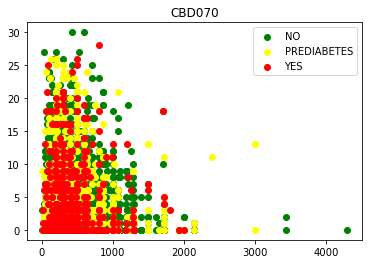

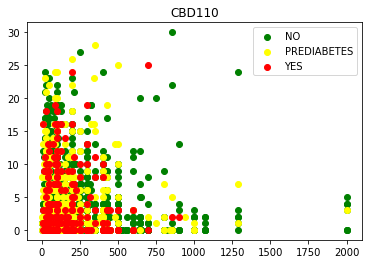

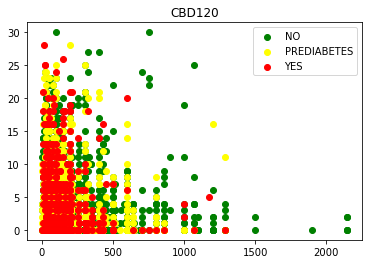

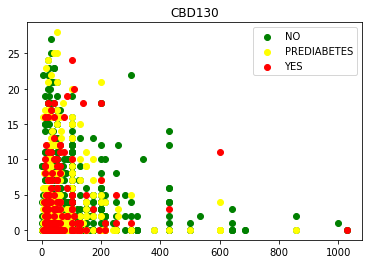

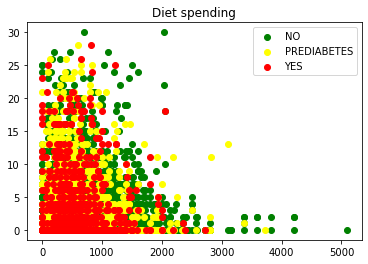

In [194]:

#sklearn
#find out, why doctors say u may have pre-diabetes using lab data

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

feature1='Depression score'
inputs=dataset[['CBD070','CBD110','CBD120','CBD130','Diet spending']]

tmp=dataset[['SEQN',feature1,'Diabetic']]

colMax=len(inputs.columns)
list1=inputs.columns.values
lgd=[
    'NO',
    'PREDIABETES',
    'YES',
]

for i in range(0,colMax):
    tmp2=tmp
    tmp2['feature']=inputs.iloc[:,i]
    string=list1[i]
    plt.figure(i)
    X1=tmp2['feature'].loc[tmp2['Diabetic']=='YES']
    X2=tmp2['feature'].loc[tmp2['Diabetic']=='PREDIABETES']
    X3=tmp2['feature'].loc[tmp2['Diabetic']=='NO']
    
    Y1=tmp2[feature1].loc[tmp2['Diabetic']=='YES']
    Y2=tmp2[feature1].loc[tmp2['Diabetic']=='PREDIABETES']
    Y3=tmp2[feature1].loc[tmp2['Diabetic']=='NO']
    
    plt.scatter(X3,Y3,c='green')
    plt.scatter(X2,Y2,c='yellow')
    plt.scatter(X1,Y1,c='red')
    plt.title(list1[i])
    plt.legend(lgd)
    
plt.show()


<ipython-input-195-a686998a7559>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp2['feature']=inputs.iloc[:,i]


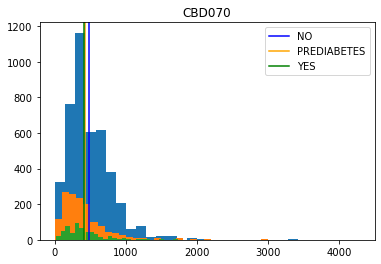

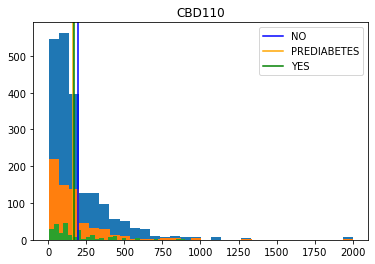

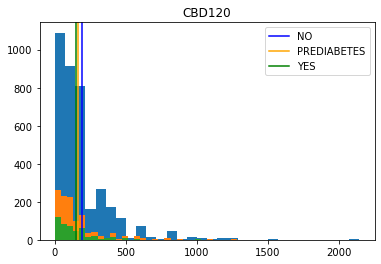

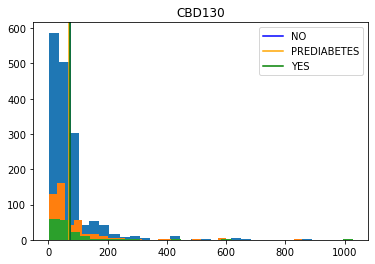

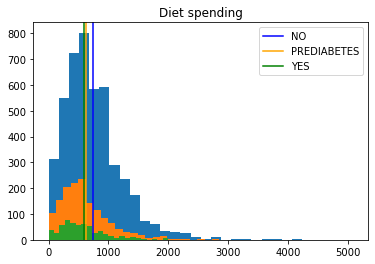

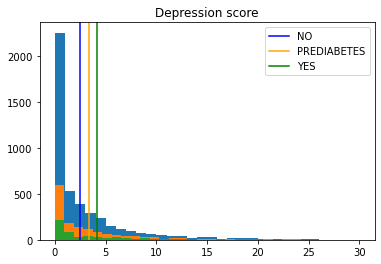

people with no diabetes spend more at supermarket/grocery store than people with prediabetes and diabetes, not yet hypothesis tested
people with diabetes then to be more depressed than people without, not yet hypothesis tested


In [195]:
#histogram
inputs=dataset[['CBD070','CBD110','CBD120','CBD130','Diet spending','Depression score']]
tmp=dataset[['SEQN',feature1,'Diabetic']]

colMax=len(inputs.columns)
list1=inputs.columns.values
lgd=[
    'NO',
    'PREDIABETES',
    'YES',
]

for i in range(0,colMax):
    tmp2=tmp
    tmp2['feature']=inputs.iloc[:,i]
    string=list1[i]
    plt.figure(i)
    X1=tmp2['feature'].loc[tmp2['Diabetic']=='YES']
    X2=tmp2['feature'].loc[tmp2['Diabetic']=='PREDIABETES']
    X3=tmp2['feature'].loc[tmp2['Diabetic']=='NO']
    plt.hist(X3,bins=30)
    plt.axvline(X3.mean(),c='blue')
    plt.hist(X2,bins=30)
    plt.axvline(X2.mean(),c='orange')
    plt.hist(X1,bins=30)
    plt.axvline(X1.mean(),c='green')
    plt.title(list1[i])
    plt.legend(lgd)
    
plt.show()
print('people with no diabetes spend more at supermarket/grocery store than people with prediabetes and diabetes, not yet hypothesis tested')
print('people with diabetes then to be more depressed than people without, not yet hypothesis tested')